In [324]:
import numpy as np

<h2>[Problem 1] Classifying fully connected layers</h2>

In [325]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1=None, n_nodes2=None, initializer=SimpleInitializer(), optimizer=SGD()):
        self.optimizer = optimizer
        # Initialize
        # Initialize self.W and self.B using the initializer method
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """       
        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        self.dA = dA
        dZ = dA @ self.W.T
        # update
        self = self.optimizer.update(self)
        return dZ

<h2>[Problem 2] Classifying the initialization method</h2>

In [326]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B : bias
        """
        return self.sigma * np.random.randn(n_nodes2)

<h2>[Problem 3] Classifying optimization methods</h2>

In [327]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        dW = layer.X.T @ layer.dA
        dB = np.sum(layer.dA, axis=0)
        layer.W -= self.lr * dW
        layer.B -= self.lr * dB
        return layer

<h2>[Problem 4] Classifying activation functions</h2>

In [328]:
class Tanh:
    def forward(self, A):
        """return Z"""
        return np.tanh(A)
    
    def backward(self, dZ, Z):
        """return dA"""
        return dZ * (1 - Z**2)

In [329]:
class Sigmoid:
    def forward(self, A):
        return 1 / (1 + np.exp(-A))
    
    def backward(self, dZ, Z):
        return dZ * ((1 - Z) * Z)

In [330]:
class Softmax:
    def forward(self, A):
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
    
    def backward(self, Z, y):
        """return dA, CEE"""
        return (Z - y) / y.shape[0], -np.sum((y * np.log(Z + 1e-7))) / y.shape[0]

<h2>[Problem 5] ReLU class creation</h2>

In [331]:
class ReLU:
    def forward(self, A):
        return np.maximum(A, 0)
    
    def backward(self, Z):
        return Z > 0 #return true false (1 0)

<h2>[Problem 6] Initial value of weight</h2>

In [332]:
class XavierInitializer:
    def __init__(self, n_nodes1):
        self.sigma = 1.0 / n_nodes1**(1/2)

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

In [333]:
class HeInitializer:
    def __init__(self, n_nodes1):
        self.sigma = (2.0 / n_nodes1)**(1/2)

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

<h2>[Problem 7] Optimization method</h2>

In [334]:
class AdaGrad:
    def __init__(self, lr=0.01, shape=None):
        self.lr = lr
        self.H = np.zeros(shape) + 1e-7

    def update(self, layer):
        dW = layer.X.T @ layer.dA
        self.H += dW**2
        layer.W -= (self.lr / self.H**(1/2)) * dW
        return layer

<h2>[Problem 8] Class completion</h2>

In [335]:
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]   

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [336]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, 
                hidden_layers=[400,200],
                hidden_activations=['tanh', 'tanh'],
                hidden_initializers=['gaussian', 'gaussian'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=20,
                epochs=10,
                lr=0.01,
                seed=0,
                verbose=False
                ):
        self.hidden_layers = hidden_layers
        self.activations_name = hidden_activations.copy()
        self.activations_name.insert(0, None)
        self.activations_name.append('softmax')
        self.initializers = hidden_initializers.copy()
        self.initializers.insert(0, None)
        self.initializers.append('gaussian')
        self.sigma = sigma
        self.optimizer = optimizer
        self.layer_type = layer_type
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.seed = seed
        self.verbose = verbose

    def _initialize_neural_network(self):
        #choose activations
        self.activations = np.full(len(self.n_nodes), None) #activations[0] unused
        for i in range(1, len(self.n_nodes)):
            if (self.activations_name[i] == 'tanh'):
                self.activations[i] = Tanh()
            elif (self.activations_name[i] == 'sigmoid'):
                self.activations[i] = Sigmoid()
            elif (self.activations_name[i] == 'relu'):
                self.activations[i] = ReLU()
            elif (self.activations_name[i] == 'softmax'):
                self.activations[i] = Softmax()
        #choose initializer, optimizer and build neural network
        self.FC = np.full(len(self.n_nodes), None) #FC[0] unused
        for i in range(1, len(self.n_nodes)):
            if (self.optimizer == 'sgd'):
                if (self.initializers[i] == 'gaussian'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], SimpleInitializer(self.sigma), SGD(self.lr))
                elif (self.initializers[i] == 'xavier'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], XavierInitializer(self.n_nodes[i - 1]), SGD(self.lr))
                elif (self.initializers[i] == 'he'):   
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], HeInitializer(self.n_nodes[i - 1]), SGD(self.lr))
            elif (self.optimizer == 'adagrad'):
                if (self.initializers[i] == 'gaussian'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], SimpleInitializer(self.sigma), AdaGrad(self.lr, (self.n_nodes[i - 1], self.n_nodes[i])))
                elif (self.initializers[i] == 'xavier'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], XavierInitializer(self.n_nodes[i - 1]), AdaGrad(self.lr, (self.n_nodes[i - 1], self.n_nodes[i])))
                elif (self.initializers[i] == 'he'):   
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], HeInitializer(self.n_nodes[i - 1]), AdaGrad(self.lr, (self.n_nodes[i - 1], self.n_nodes[i])))

    def _forward(self, X):
        A = np.full(len(self.n_nodes), None) #A[0] unused
        Z = np.full(len(self.n_nodes), None)
        Z[0] = X
        for i in range(1, len(self.n_nodes)):
            A[i] = self.FC[i].forward(Z[i - 1])
            Z[i] = self.activations[i].forward(A[i])
        return Z

    def _backward(self, y, Z):
        dA = np.full(len(self.n_nodes), None) #A[0] unused
        dZ = np.full(len(self.n_nodes), None) #Z[-1] unused
        CEE = None
        for i in range(len(self.n_nodes) - 1, 0, -1):
            if (self.activations_name[i] == 'tanh' or self.activations_name[i] == 'sigmoid'):
                dA[i] = self.activations[i].backward(dZ[i], Z[i])
            elif (self.activations_name[i] == 'relu'):
                dA[i] = self.activations[i].backward(Z[i])
            elif (self.activations_name[i] == 'softmax'):
                dA[i], CEE = self.activations[i].backward(Z[i], y)
            dZ[i - 1] = self.FC[i].backward(dA[i])
        return CEE

    def _optimize(self, X, y):
        CEE_list = []
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.seed)
        for _ in range(0, self.epochs):
            for mini_X, mini_y in get_mini_batch:
                Z = self._forward(mini_X)
                CEE = self._backward(mini_y, Z)
                CEE_list.append(CEE)
        return np.array(CEE_list)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        self.n_output = y.shape[1]
        self.n_features = X.shape[1]
        self.n_nodes = self.hidden_layers.copy()
        self.n_nodes.insert(0, self.n_features)
        self.n_nodes.append(self.n_output)
        self._initialize_neural_network()
        self.CEE_list = self._optimize(X, y)
        if (X_val is not None and y_val is not None):
            self.CEE_list_val = self._optimize(X_val, y_val)

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        Z_pred = self._forward(X)
        return np.argmax(Z_pred[-1], axis=1)

<h2>[Problem 9] Learning and estimation</h2>

In [337]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

In [338]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [339]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [340]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [341]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [342]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [343]:
def plot_CEE(CEE_list=None, CEE_list_val=None, epochs=None):
    """plot final CEE for every epochs"""
    if (CEE_list is not None):
        plt.plot(np.arange(0, CEE_list.shape[0]), CEE_list, color='gray', alpha=0.5)
        plt.plot(np.arange(0, CEE_list.shape[0], int(CEE_list.shape[0]/epochs)), CEE_list[::int(CEE_list.shape[0]/epochs)], label="train", marker='o')
    if (CEE_list_val is not None):
        plt.plot(np.arange(0, epochs), CEE_list_val[::int(CEE_list_val.shape[0]/epochs)], label="val", marker='o')
    plt.legend()
    plt.xlabel("iter")
    plt.ylabel("CEE")
    plt.title("CEE graph")
    plt.grid()
    plt.show()

In [344]:
def draw_fault(y_pred, y_val):
    """
    Display word classification results side by side. The display above the image is "estimated result / correct answer".
    Parameters:
    ----------
    y_pred : Estimated ndarray (n_samples,)
    y_val : Correct label of verification data (n_samples,)
    X_val : Verification data features (n_samples, n_features)
    """
    num = 36 # How many to display

    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

In [345]:
def save_model(model_name, model):
    np.savez(model_name + '.npz', model)

In [ ]:
import time

In [346]:
def handler(model=None, X_train=None, y_train=None, X_val=None, y_val=None, epochs=None, save=False, file_name=None):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    unique_elements, counts_elements = np.unique(y_pred - np.argmax(y_val, axis=1), return_counts=True)
    print("number of correct cases: {}/{}".format(int(counts_elements[unique_elements == 0]), y_pred.shape[0]))
    print("Accuracy: {}".format(accuracy_score(np.argmax(y_val, axis=1), y_pred)))
    plot_CEE(CEE_list=model.CEE_list, epochs=epochs)
    draw_fault(y_pred, np.argmax(y_val, axis=1))
    if (save == True):
        save_model('file_name', model)
    end = time.time()
    print("Time taken: {}s".format(end - start))

<h3>Case 1</h3>

In [347]:
epochs = 10
batch_size = 20

number of correct cases: 11577/12000
Accuracy: 0.96475


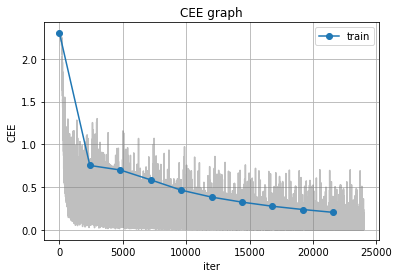

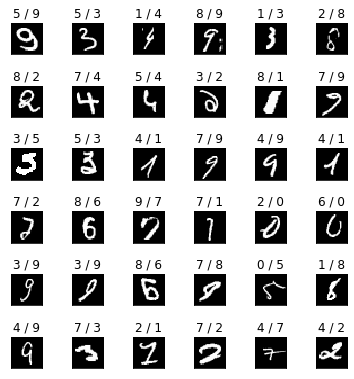

In [348]:
dnn_1 = ScratchDeepNeuralNetrowkClassifier(
                hidden_layers=[400,200],
                hidden_activations=['tanh', 'tanh'],
                hidden_initializers=['gaussian', 'gaussian'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.05,
                seed=69,
                verbose=False       
)

handler(dnn_1, X_train, y_train, X_val, y_val, epochs)

<h3>Case 2 - use different activation functions and initializers</h3>

number of correct cases: 11576/12000
Accuracy: 0.9646666666666667


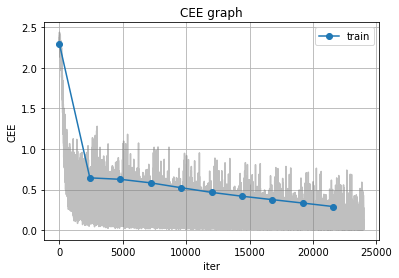

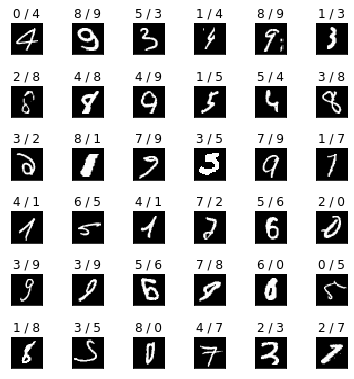

In [353]:
dnn_2 = ScratchDeepNeuralNetrowkClassifier(
                hidden_layers=[400,200],
                hidden_activations=['tanh', 'sigmoid'],
                hidden_initializers=['xavier', 'xavier'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.05,
                seed=69,
                verbose=False       
)

handler(dnn_2, X_train, y_train, X_val, y_val, epochs)

In [ ]:
dnn_2 = ScratchDeepNeuralNetrowkClassifier(
                hidden_layers=[400,200],
                hidden_activations=['relu', 'relu'],
                hidden_initializers=['he', 'he'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.0005,
                seed=69,
                verbose=False       
)

handler(dnn_2, X_train, y_train, X_val, y_val, epochs)

<h3>Case 3 - use AdaGrad optimizer</h3>

number of correct cases: 11696/12000
Accuracy: 0.9746666666666667


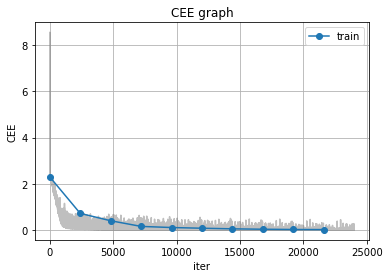

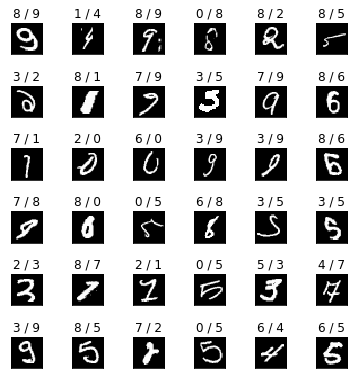

In [356]:
dnn_3 = ScratchDeepNeuralNetrowkClassifier(
                hidden_layers=[400,200],
                hidden_activations=['tanh', 'sigmoid'],
                hidden_initializers=['xavier', 'he'],
                sigma=0.01,
                optimizer='adagrad',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.05,
                seed=69,
                verbose=False       
)

handler(dnn_3, X_train, y_train, X_val, y_val, epochs)

<h3>Case 4 - add 2 more layers</h3>

In [ ]:
dnn_4 = ScratchDeepNeuralNetrowkClassifier(
                hidden_layers=[400,200,200,400],
                hidden_activations=['tanh', 'sigmoid', 'sigmoid', 'tanh'],
                hidden_initializers=['he', 'xavier', 'xavier', 'he'],
                sigma=0.01,
                optimizer='adagrad',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.05,
                seed=69,
                verbose=False       
)

handler(dnn_4, X_train, y_train, X_val, y_val, epochs)

In [ ]:
dnn_4 = ScratchDeepNeuralNetrowkClassifier(
                hidden_layers=[400,200,200,400],
                hidden_activations=['relu', 'relu', 'relu', 'relu'],
                hidden_initializers=['he', 'he', 'he', 'he'],
                sigma=0.01,
                optimizer='adagrad',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.05,
                seed=69,
                verbose=False       
)

handler(dnn_4, X_train, y_train, X_val, y_val, epochs)